<a href="https://colab.research.google.com/github/YoshifumiMiyagi/NIH14_CHESTXP/blob/main/Thoracic_Cropping_Using_Lung_Field_Segmentation%2Bfinal_seed__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.models as tv_models
import timm
import torch.nn as nn
from sklearn.model_selection import StratifiedGroupKFold
import random
from pathlib import Path

from sklearn.metrics import roc_auc_score

import torchvision.models as tv_models
import timm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.models as tv


# 512×512リサイズのsample data 3400例（No-findingsだけ）

In [ ]:
data = np.load("/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/cxr_pediatric_images512_age_under18_patients_sex_3400.npy", allow_pickle=True).item()
imgs = data["images"]
ages = data["ages"]
pids = data['patient_id']
sex = data['sex']


print("Images:", imgs.shape, imgs.min(), imgs.max())

Images: (3400, 512, 512) 0.0 1.0


# 前処理(Preprocessing)

In [ ]:
N = len(imgs)
imgs_sc = imgs.copy()

for i in range(N):

    x = imgs[i].astype(np.float32)

    # percentile clipping
    p1, p99 = np.percentile(x, (1,99))
    x = np.clip(x, p1, p99)

    # normalize
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)

    # CLAHE
    x8 = (x*255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x8).astype(np.float32) / 255.0

    # Bone enhancement
    blur = cv2.GaussianBlur(x, (0,0), 3)
    x = cv2.addWeighted(x, 1.5, blur, -0.5, 0)
    x = np.clip(x, 0, 1)

    # 最後にもう一度 normalize
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)

    imgs_sc[i] = x

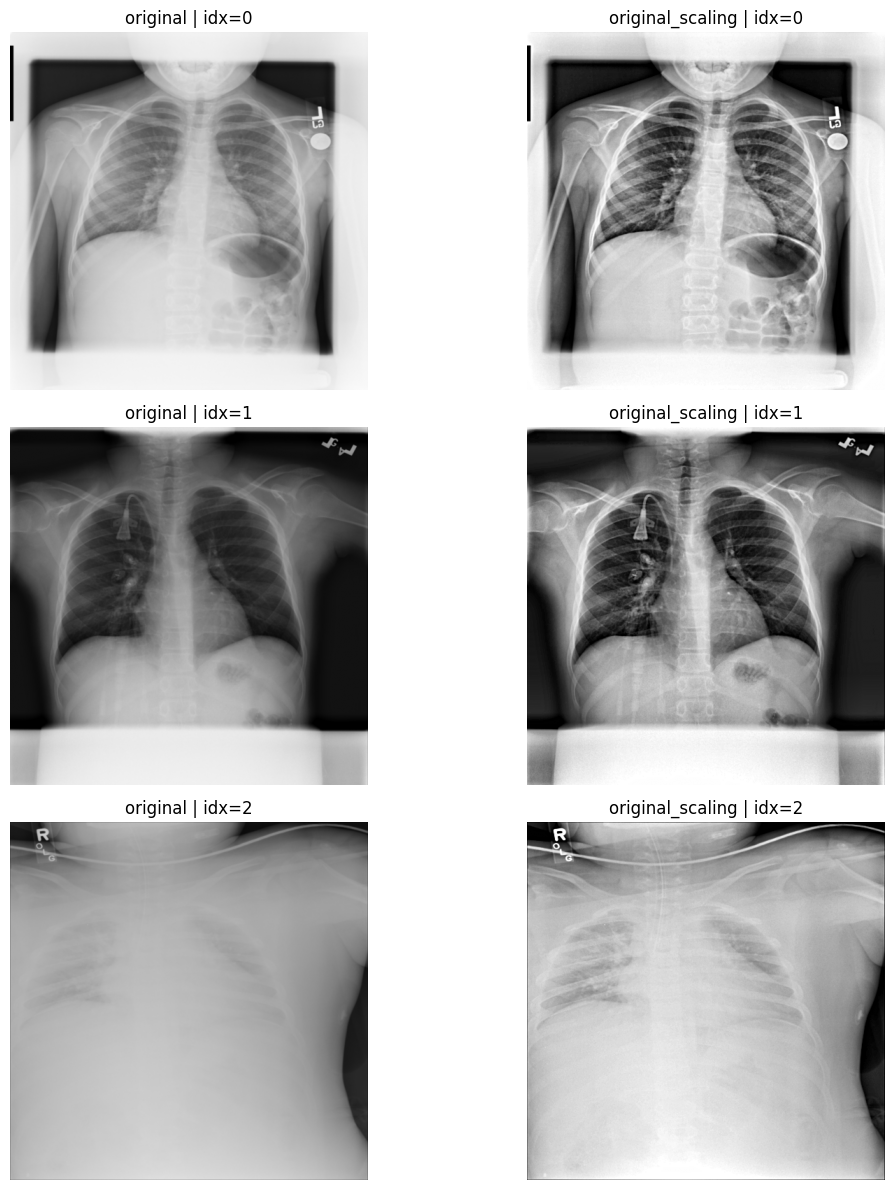

In [ ]:
idxs = [0, 1, 2]

def show_triplets(idxs):
    n = len(idxs)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)

    for r, i in enumerate(idxs):
        orig = imgs[i]
        orig_sc = imgs_sc[i]
        for c, (img, title) in enumerate([(orig, "original"),
                                          (orig_sc, "original_scaling"),
                                         ]):
            ax = axes[r, c]
            ax.imshow(img, cmap="gray", vmin=0, vmax=1)
            ax.set_title(f"{title} | idx={i}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_triplets(idxs)


# Dataset作成

In [ ]:
age_bins = [0, 5, 10, 15, 19]  # 0-4, 5-9, 10-14, 15-18
age_bin = pd.cut(ages, bins=age_bins, right=False, include_lowest=True)

strata = age_bin.astype(str) + "__" + sex.astype(str)

def sex_to_int(s):

    ss = str(s).strip().lower()
    if ss in ["m", "male", "man", "1", "true"]:
        return 0
    if ss in ["f", "female", "woman", "0", "false"]:
        return 1

In [ ]:
class EVACXRDataset(Dataset):
    def __init__(self, images, ages, sex):
        self.images = images
        self.ages = ages
        self.sex = sex

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        # numpy -> torch
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img)

        img = img.float()

        # [H,W] -> [1,H,W]
        if img.ndim == 2:
            img = img.unsqueeze(0)

        # 1ch -> 3ch (ImageNet重み/一般CNN用)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        # ★ここが抜けていた
        age = self.ages[idx]
        sex = self.sex[idx]
        sex_i = sex_to_int(sex)
        # numpy scalar -> python scalar 対応
        if isinstance(age, np.generic):
            age = age.item()
        if isinstance(sex, np.generic):
            sex = sex.item()
        return img, torch.tensor(age, dtype=torch.float32), torch.tensor(sex_i, dtype=torch.long)

full_ds = EVACXRDataset(
    images=imgs,
    ages=ages,
    sex=sex
)

# Train, val, test = 7:1:2 StratiriedGroupKFoldでGroup重複回避+層別化維持でSplit

In [ ]:
# =========================
# 0) Reproducibility (deterministic)
# =========================
import os, random
import numpy as np
import torch

# Note: CUBLAS_WORKSPACE_CONFIG should ideally be set before the first CUDA call
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

def set_seed(seed=42, deterministic=False):
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

# Disabling strict deterministic mode to avoid CuBLAS runtime error
set_seed(42, deterministic=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def worker_init_fn(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(42)



In [ ]:
# まず test を切る
sgkf_test = StratifiedGroupKFold(
    n_splits=5, shuffle=True, random_state=42
)

trainval_idx, test_idx = next(
    sgkf_test.split(
        np.zeros(len(strata)),
        y=strata,
        groups=pids
    )
)
trainval_ds = Subset(full_ds, trainval_idx)

# trainval 内の配列を作る
pids_tv   = np.asarray(pids)[trainval_idx]
strata_tv = np.asarray(strata)[trainval_idx]

sgkf_val = StratifiedGroupKFold(
    n_splits=8, shuffle=True, random_state=42
)

tr2, va2 = next(
    sgkf_val.split(
        np.zeros(len(strata_tv)),
        y=strata_tv,
        groups=pids_tv
    )
)

train_idx = trainval_idx[tr2]
val_idx   = trainval_idx[va2]

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

print("N (train/val/test):", len(train_idx), len(val_idx), len(test_idx))
print(
    "unique patients:",
    len(np.unique(pids[train_idx])),
    len(np.unique(pids[val_idx])),
    len(np.unique(pids[test_idx]))
)


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
test_loader   = DataLoader(test_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)



N (train/val/test): 2370 333 697
unique patients: 1038 151 298


# Model実行

In [ ]:

# =========================
# 1) Model builders
# =========================
def build_torchvision(name: str, num_classes=2):
    name = name.lower()

    if name == "resnet18":
        m = tv_models.resnet18(weights=tv_models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m

    if name == "resnet50":
        m = tv_models.resnet50(weights=tv_models.ResNet50_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m

    if name == "resnet101":
        m = tv_models.resnet101(weights=tv_models.ResNet101_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m

    if name == "densenet121":
        m = tv_models.densenet121(weights=tv_models.DenseNet121_Weights.IMAGENET1K_V1)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
        return m

    if name == "convnext_tiny":
        m = tv_models.convnext_tiny(weights=tv_models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        m.classifier[2] = nn.Linear(m.classifier[2].in_features, num_classes)
        return m

    if name == "vit_b_16":
        m = tv_models.vit_b_16(weights=tv_models.ViT_B_16_Weights.IMAGENET1K_V1)
        m.heads.head = nn.Linear(m.heads.head.in_features, num_classes)
        return m

    if name == "swin_t":
        m = tv_models.swin_t(weights=tv_models.Swin_T_Weights.IMAGENET1K_V1)
        m.head = nn.Linear(m.head.in_features, num_classes)
        return m

    raise ValueError(f"[torchvision] Unknown model: {name}")


def build_timm(name: str, num_classes=2):
    # timmは num_classes を指定すると最終層を自動置換してくれます
    return timm.create_model(name, pretrained=True, num_classes=num_classes)


def build_model_any(name: str, num_classes=2):
    tv_names = {"resnet18","resnet50","densenet121","convnext_tiny","vit_b_16","swin_t"}
    if name.lower() in tv_names:
        return build_torchvision(name, num_classes=num_classes)
    return build_timm(name, num_classes=num_classes)


# =========================
# 2) Train / Predict
# =========================
def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=True):
    model.train()
    total_loss = 0.0

    device_type = "cuda" if str(device).startswith("cuda") else "cpu"
    amp_enabled = bool(use_amp and device_type == "cuda")
    scaler = torch.amp.GradScaler(device_type, enabled=amp_enabled)

    if device_type == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()

    for x, age, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type, enabled=amp_enabled):
            logits = model(x)
            loss = criterion(logits, y)

        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += float(loss.item())

    if device_type == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    return total_loss / max(len(loader), 1), (t1 - t0)




@torch.no_grad()
def predict_probs_labels_ages(model, loader, device, use_amp=True):
    model.eval()

    device_type = "cuda" if str(device).startswith("cuda") else "cpu"
    amp_enabled = bool(use_amp and device_type == "cuda")

    probs_list, y_list, age_list = [], [], []

    if device_type == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()

    for x, age, y in loader:
        x = x.to(device, non_blocking=True)

        with torch.amp.autocast(device_type, enabled=amp_enabled):
            logits = model(x)
            prob = torch.softmax(logits, dim=1)[:, 1]

        probs_list.append(prob.detach().cpu().numpy())
        y_list.append(y.numpy() if hasattr(y, "numpy") else np.asarray(y))
        age_list.append(age.numpy() if hasattr(age, "numpy") else np.asarray(age))

    if device_type == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    probs = np.concatenate(probs_list)
    y = np.concatenate(y_list)
    age = np.concatenate(age_list)
    return probs, y, age, (t1 - t0)


def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    if y_true.size == 0 or np.unique(y_true).size < 2:
        return float("nan")

    return float(roc_auc_score(y_true, y_prob))



def auc_by_age_bins(probs, labels, ages, bins, min_n=20):
    rows = []
    for lo, hi in bins:
        idx = (ages >= lo) & (ages <= hi)
        n = int(idx.sum())
        auc = float("nan")
        if n >= min_n and np.unique(labels[idx]).size >= 2:
            auc = roc_auc_score(labels[idx], probs[idx])
        rows.append((f"{lo}-{hi}", n, auc))
    return rows

In [ ]:

# =========================
# 3) Run all models
# =========================
def run_all_models(
    model_names,
    train_loader, val_loader, test_loader,
    age_bins=((0,4),(5,9),(10,14),(15,18)),
    epochs=10,
    base_lr=1e-4,
    save_root="checkpoints_compare",
    use_amp=True,
    save_test_probs=True,
):
    save_root = Path(save_root)
    save_root.mkdir(parents=True, exist_ok=True)

    results = []
    probs_dict = {}

    for name in model_names:
        print("\n" + "="*80)
        print(f"MODEL: {name}")

        model = build_model_any(name, num_classes=2).to(device)

        lr = base_lr
        if "eva02" in name.lower():
            lr = base_lr * 0.5

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

        best_val_auc = -1.0
        best_path = save_root / f"{name.replace('/','_')}_best.pth"

        if device == "cuda":
            torch.cuda.synchronize()
        t_model0 = time.perf_counter()

        epoch_times = []
        val_pred_times = []

        for epoch in range(1, epochs + 1):
            loss, t_train = train_one_epoch(model, train_loader, optimizer, criterion, device, use_amp=use_amp)
            epoch_times.append(t_train)

            val_probs, val_y, val_age, t_valpred = predict_probs_labels_ages(model, val_loader, device, use_amp=use_amp)
            val_pred_times.append(t_valpred)

            val_auc = safe_auc(val_y, val_probs)

            print(
                f"[{name}] epoch {epoch:02d}/{epochs} "
                f"loss={loss:.4f} val_auc={val_auc:.3f} "
                f"train_time={t_train:.1f}s val_pred_time={t_valpred:.1f}s lr={lr:g}"
            )

            if np.isfinite(val_auc) and val_auc > best_val_auc:
                best_val_auc = val_auc
                torch.save(model.state_dict(), best_path)
                print("  -> saved best")

        if best_path.exists():
            model.load_state_dict(torch.load(best_path, map_location=device))

        test_probs, test_y, test_age, t_testpred = predict_probs_labels_ages(model, test_loader, device, use_amp=use_amp)

        test_probs = np.asarray(test_probs)
        test_y = np.asarray(test_y)
        test_age = np.asarray(test_age)

        if save_test_probs:
            probs_dict[name] = {
                "prob": test_probs,
                "y": test_y,
                "age": test_age
            }
            np.save(save_root / f"test_prob_{name.replace('/','_')}.npy", test_probs)

        test_auc_all = safe_auc(test_y, test_probs)
        test_bins = auc_by_age_bins(test_probs, test_y, test_age, bins=age_bins)

        if device == "cuda":
            torch.cuda.synchronize()
        t_model1 = time.perf_counter()

        t_train_total = float(np.sum(epoch_times))
        t_valpred_total = float(np.sum(val_pred_times))
        t_total = (t_model1 - t_model0)

        row = {
            "model": name,
            "val_auc_best": best_val_auc,
            "test_auc_all": test_auc_all,
            "time_total_sec": t_total,
            "time_train_total_sec": t_train_total,
            "time_train_epoch_mean_sec": float(np.mean(epoch_times)),
            "time_val_pred_total_sec": t_valpred_total,
            "time_test_pred_sec": float(t_testpred),
        }
        for bin_name, n, auc in test_bins:
            row[f"test_auc_{bin_name}"] = auc
            row[f"n_{bin_name}"] = n

        results.append(row)

        print(f"[{name}] TEST AUC(all) = {test_auc_all:.3f}")
        print("  test bins:", test_bins)

    df = pd.DataFrame(results).sort_values("test_auc_all", ascending=False)
    df.to_csv(save_root / "results_compare.csv", index=False)

    return df, probs_dict

# =========================
# 4) Choose model list & run
# =========================
model_names = [
    "resnet18",
]

age_bins = [(0,4),(5,9),(10,14),(15,18)]

df_results, probs_dict = run_all_models(
    model_names,
    train_loader, val_loader, test_loader,
    age_bins=((0,4),(5,9),(10,14),(15,18)),
    epochs=10,
    base_lr=1e-4,
    save_root="checkpoints_compare",
    use_amp=False,
    save_test_probs=True,
)

print("\n=== Summary ===")
print(df_results)


MODEL: resnet18
[resnet18] epoch 01/10 loss=0.5132 val_auc=0.856 train_time=37.8s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 02/10 loss=0.2266 val_auc=0.883 train_time=35.1s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 03/10 loss=0.0944 val_auc=0.872 train_time=36.2s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 04/10 loss=0.0341 val_auc=0.881 train_time=35.8s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 05/10 loss=0.0300 val_auc=0.878 train_time=36.0s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 06/10 loss=0.1202 val_auc=0.880 train_time=36.1s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 07/10 loss=0.1162 val_auc=0.836 train_time=35.9s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 08/10 loss=0.1524 val_auc=0.874 train_time=35.8s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 09/10 loss=0.0895 val_auc=0.888 train_time=35.8s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 10/10 loss=0.0461 val_auc=0.886 train_time=36.0s val_pred_time=

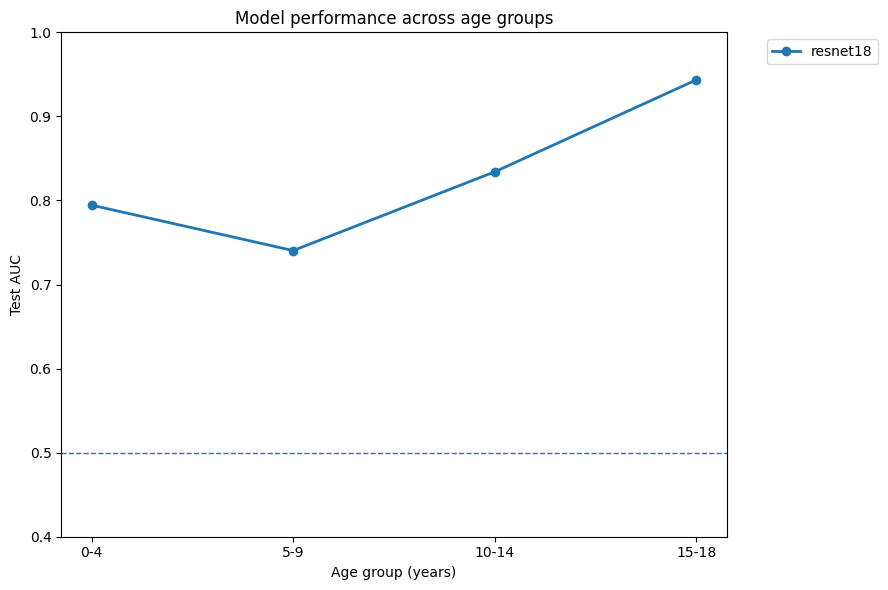

In [ ]:
df = df_results.copy()  # ← いまの Summary DataFrame

age_bins = ["0-4", "5-9", "10-14", "15-18"]
auc_cols = {
    "0-4": "test_auc_0-4",
    "5-9": "test_auc_5-9",
    "10-14": "test_auc_10-14",
    "15-18": "test_auc_15-18",
}

rows = []
for _, r in df.iterrows():
    for age in age_bins:
        rows.append({
            "model": r["model"],
            "age_bin": age,
            "auc": r[auc_cols[age]]
        })

df_long = pd.DataFrame(rows)

plt.figure(figsize=(9,6))

# Loop variable renamed from 'g' to 'df_group' to avoid conflict with torch.Generator
for model, df_group in df_long.groupby("model"):
    plt.plot(
        df_group["age_bin"],
        df_group["auc"],
        marker="o",
        linewidth=2,
        label=model
    )

plt.axhline(0.5, linestyle="--", linewidth=1)
plt.ylim(0.4, 1.0)

plt.xlabel("Age group (years)")
plt.ylabel("Test AUC")
plt.title("Model performance across age groups")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Using Preprocessing

In [ ]:
MODEL_NAMES = ['resnet18']

full_ds = EVACXRDataset(images=imgs_sc, ages=ages, sex=sex)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
test_loader   = DataLoader(test_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)

age_bins = [(0,4),(5,9),(10,14),(15,18)]

df_results2, probs_dict2 = run_all_models(
    MODEL_NAMES,
    train_loader, val_loader, test_loader,
    age_bins=((0,4),(5,9),(10,14),(15,18)),
    epochs=10,
    base_lr=1e-4,
    save_root="checkpoints_compare",
    use_amp=False,
    save_test_probs=True,
)

print("\n=== Summary ===")
print(df_results2)


MODEL: resnet18
[resnet18] epoch 01/10 loss=0.5184 val_auc=0.848 train_time=36.2s val_pred_time=2.1s lr=0.0001
  -> saved best
[resnet18] epoch 02/10 loss=0.2195 val_auc=0.861 train_time=35.9s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 03/10 loss=0.0697 val_auc=0.895 train_time=36.2s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 04/10 loss=0.0309 val_auc=0.883 train_time=35.9s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 05/10 loss=0.0118 val_auc=0.890 train_time=35.8s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 06/10 loss=0.0076 val_auc=0.889 train_time=35.9s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 07/10 loss=0.0045 val_auc=0.900 train_time=36.1s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 08/10 loss=0.0031 val_auc=0.902 train_time=35.8s val_pred_time=2.0s lr=0.0001
  -> saved best
[resnet18] epoch 09/10 loss=0.0090 val_auc=0.879 train_time=35.7s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 10/10 loss=0.0709 val_auc=0.833

# Thoracic Cropping Using Lung Field Segmentation

In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image

IMG_DIR = Path("/content/drive/MyDrive/PedAI_ChestXp/MiniModel_ChestXp/rawdata/age_1-4_indices_20260208_083807")
MASK168 = Path('/content/drive/MyDrive/PedAI_ChestXp/MiniModel_ChestXp/rawdata/age1_4_mask_stack_168.npy')
OUT_DIR = Path("/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)")
OUT_DIR.mkdir(exist_ok=True)

SIZE = 512

# --- 画像168枚（ファイル名順）
img_files = sorted(IMG_DIR.glob("*.png"), key=lambda p: p.name)

# --- mask47 load
m168 = np.load(MASK168, mmap_mode="r")
if m168.ndim == 4:
    m168 = m168[..., 0]
assert m168.shape[0] == 168, m168.shape

# --- resize & stack
X = np.zeros((168, SIZE, SIZE), np.float32)
Y = np.zeros((168, SIZE, SIZE), np.uint8)

for i, ip in enumerate(img_files):
    # image
    img = Image.open(ip).convert("L").resize((SIZE, SIZE), Image.BILINEAR)
    x = np.array(img, np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    X[i] = x

    # mask
    m = (m168[i] > 0).astype(np.uint8)
    m = Image.fromarray(m * 255).resize((SIZE, SIZE), Image.NEAREST)
    Y[i] = (np.array(m) > 0).astype(np.uint8)

np.save(OUT_DIR / "image_stack_168.npy", X)
np.save(OUT_DIR / "mask_stack_168.npy",  Y)

print("saved:", OUT_DIR)
print("X:", X.shape, X.dtype, "range:", float(X.min()), float(X.max()))
print("Y:", Y.shape, Y.dtype, "unique:", np.unique(Y))

saved: /content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)
X: (168, 512, 512) float32 range: 0.0 1.0
Y: (168, 512, 512) uint8 unique: [0 1]


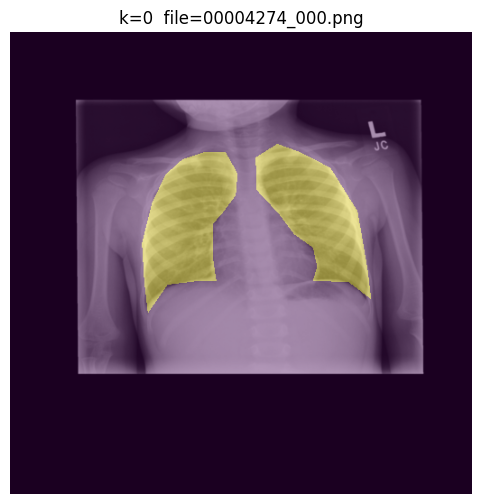

In [ ]:
import matplotlib.pyplot as plt

k = 0  # 0,10,20... 変えて数枚見る
plt.figure(figsize=(6,6))
plt.imshow(X[k], cmap="gray")
plt.imshow(Y[k], alpha=0.4)
plt.title(f"k={k}  file={img_files[k].name}")
plt.axis("off")
plt.show()

In [ ]:
# -------------------------
# 1) Dataset (indices + aug + resize)
# -------------------------
class StackSegDataset(Dataset):
    def __init__(self, X, Y, indices=None, size=512, do_aug=False):
        self.X = X
        self.Y = Y
        self.size = size
        self.do_aug = do_aug
        if indices is None:
            self.indices = np.arange(len(Y))
        else:
            self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, k):
        i = int(self.indices[k])
        img = np.asarray(self.X[i])
        mask = np.asarray(self.Y[i])

        # mask RGBA/多ch -> 1ch
        if mask.ndim == 3:
            mask = mask[..., 0]

        # resize
        img  = cv2.resize(img,  (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # binarize
        mask = (mask > 0).astype(np.float32)

        # to tensor: (1,H,W)
        img  = torch.from_numpy(img).float().unsqueeze(0)
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        # normalize per-image to [0,1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # mild aug (safe)
        if self.do_aug:
            if torch.rand(1).item() < 0.5:
                img  = torch.flip(img,  dims=[2])
                mask = torch.flip(mask, dims=[2])
            if torch.rand(1).item() < 0.8:
                gain = 1.0 + (torch.rand(1).item() - 0.5) * 0.10
                bias = (torch.rand(1).item() - 0.5) * 0.05
                img = torch.clamp(img * gain + bias, 0.0, 1.0)

        return img, mask

# -------------------------
# 2) ResNet18-UNet (pretrained encoder)
# -------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv2(self.conv1(x))
        return x

class ResNet18UNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        m = tv.resnet18(weights=tv.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        self.conv1 = m.conv1
        self.bn1   = m.bn1
        self.relu  = m.relu
        self.maxpool = m.maxpool

        self.layer1 = m.layer1  # 64
        self.layer2 = m.layer2  # 128
        self.layer3 = m.layer3  # 256
        self.layer4 = m.layer4  # 512

        self.bridge = nn.Sequential(
            ConvBNReLU(512, 512),
            ConvBNReLU(512, 512),
        )

        self.dec4 = DecoderBlock(512, 512, 256)
        self.dec3 = DecoderBlock(256, 256, 128)
        self.dec2 = DecoderBlock(128, 128, 64)
        self.dec1 = DecoderBlock(64,  64,  64)

        self.head = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        x0 = self.relu(self.bn1(self.conv1(x)))  # (B,64,H/2,W/2)
        x1 = self.maxpool(x0)                    # (B,64,H/4,W/4)

        e1 = self.layer1(x1)                     # (B,64,H/4,W/4)
        e2 = self.layer2(e1)                     # (B,128,H/8,W/8)
        e3 = self.layer3(e2)                     # (B,256,H/16,W/16)
        e4 = self.layer4(e3)                     # (B,512,H/32,W/32)

        b  = self.bridge(e4)                     # (B,512,H/32,W/32)

        d4 = self.dec4(b,  e4)                   # (B,256,H/32,W/32)
        d3 = self.dec3(d4, e3)                   # (B,128,H/16,W/16)
        d2 = self.dec2(d3, e2)                   # (B,64, H/8, W/8)
        d1 = self.dec1(d2, e1)                   # (B,64, H/4, W/4)

        out = F.interpolate(d1, scale_factor=4, mode="bilinear", align_corners=False)  # back to H,W
        return self.head(out)  # logits


# -------------------------
# 3) Loss / metric (Dice + BCEWithLogits)
# -------------------------
#bce = nn.BCEWithLogitsLoss()

pos_weight = torch.tensor([3.0], device=device)  # まず2〜5で試す
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def dice_loss_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.flatten(1)     # [B, HW]
    targets = targets.flatten(1) # [B, HW]
    inter = (probs * targets).sum(1)
    den = probs.sum(1) + targets.sum(1)
    dice = (2*inter + eps) / (den + eps)
    return (1 - dice).mean()


def loss_fn(logits, targets, w_dice=0.7):
    return w_dice * dice_loss_logits(logits, targets) + (1-w_dice) * bce(logits, targets)

@torch.no_grad()
def dice_score_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

@torch.no_grad()
def soft_dice_score_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    inter = (probs * targets).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

@torch.no_grad()
def best_dice_over_thresholds(logits, targets, thrs=(0.2,0.3,0.4,0.5,0.6), eps=1e-6):
    probs = torch.sigmoid(logits)
    best = -1
    best_thr = None
    for thr in thrs:
        preds = (probs > thr).float()
        inter = (preds * targets).sum(dim=(2,3))
        union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        d = ((2*inter + eps) / (union + eps)).mean().item()
        if d > best:
            best, best_thr = d, thr
    return best, best_thr


# -------------------------
# 4) Train helper (freeze->unfreeze, AMP, early stop)
# -------------------------
def set_encoder_trainable(model, trainable: bool):
    enc_params = []
    enc_params += list(model.conv1.parameters())
    enc_params += list(model.bn1.parameters())
    enc_params += list(model.layer1.parameters())
    enc_params += list(model.layer2.parameters())
    enc_params += list(model.layer3.parameters())
    enc_params += list(model.layer4.parameters())
    for p in enc_params:
        p.requires_grad = trainable

def run_train(
    model, train_loader, val_loader,
    epochs=80, lr=2e-4, weight_decay=1e-4,
    unfreeze_epoch=10, unfreeze_lr=1e-4,
    patience=15, save_path="best.pt",
    use_amp=True,   # ★追加（必要なら呼び出しで切替）
):
    model = model.to(device)

    # ★torch.amp は device_type が必須
    device_type = "cuda" if str(device).startswith("cuda") else "cpu"
    amp_enabled = bool(use_amp and device_type == "cuda")
    scaler = torch.amp.GradScaler(device_type, enabled=amp_enabled)

    # phase1: freeze encoder
    set_encoder_trainable(model, False)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=weight_decay
    )

    train_losses, val_losses_hist, val_dices = [], [], []
    best = -1.0
    bad = 0

    save_path = Path(save_path).expanduser().resolve()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    print("✅ saving to:", str(save_path))

    for ep in range(1, epochs + 1):
        # unfreeze
        if ep == unfreeze_epoch + 1:
            set_encoder_trainable(model, True)
            optimizer = torch.optim.AdamW(model.parameters(), lr=unfreeze_lr, weight_decay=weight_decay)
            print(f"✅ encoder unfrozen @epoch {ep}, lr={unfreeze_lr}")

        # -----------------
        # train
        # -----------------
        model.train()
        tr_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type, enabled=amp_enabled):
                logits = model(xb)
                loss = loss_fn(logits, yb, w_dice=0.7)

            if amp_enabled:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            tr_loss += loss.item() * xb.size(0)

        tr_loss /= len(train_loader.dataset)

        # -----------------
        # val（あなたの評価は維持しつつ、重複ループは1回に統合）
        # -----------------
        model.eval()

        val_loss_list = []
        hard_dices = []
        soft_dices = []
        best_dices = []

        va_loss = 0.0
        va_dice = 0.0
        n = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                with torch.amp.autocast(device_type, enabled=amp_enabled):
                    logits = model(xb)
                    loss = loss_fn(logits, yb, w_dice=0.7)

                val_loss_list.append(loss.item())
                hard_dices.append(dice_score_logits(logits, yb))
                soft_dices.append(soft_dice_score_logits(logits, yb))
                best_d, best_thr = best_dice_over_thresholds(logits, yb)
                best_dices.append(best_d)

                bs = xb.size(0)
                va_loss += loss.item() * bs
                va_dice += dice_score_logits(logits, yb) * bs
                n += bs

        va_loss /= max(n, 1)
        va_dice /= max(n, 1)

        print("val_loss:", float(np.mean(val_loss_list)))
        print("hard dice (0.5):", float(np.mean(hard_dices)))
        print("soft dice:", float(np.mean(soft_dices)))
        print("best thr dice:", float(np.mean(best_dices)))

        train_losses.append(tr_loss)
        val_losses_hist.append(va_loss)
        val_dices.append(va_dice)

        print(f"Epoch {ep:03d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_dice {va_dice:.4f}")

        # save best
        if va_dice > best + 1e-4:
            best = va_dice
            bad = 0
            torch.save({"model": model.state_dict(), "best_val_dice": best}, save_path)
            print("  ✅ saved best:", best)
        else:
            bad += 1
            if bad >= patience:
                print("  ⏹ early stopping. best val dice:", best)
                break

    return {
        "train_losses": train_losses,
        "val_losses": val_losses_hist,
        "val_dices": val_dices,
        "best": best,
        "save_path": str(save_path),
    }


# -------------------------
# 5) Prepare your arrays here
# -------------------------

# -------------------------
# 6) Split function
# -------------------------
def make_split_loaders(X, Y, size=512, batch_size=2, seed=42):
    idx = np.arange(len(X))
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)
    n_val = max(3, int(len(X)*0.2))
    val_idx = idx[:n_val]
    trn_idx = idx[n_val:]

    train_ds = StackSegDataset(X, Y, indices=trn_idx, size=size, do_aug=True)
    val_ds   = StackSegDataset(X, Y, indices=val_idx, size=size, do_aug=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # quick check
    xb, yb = next(iter(train_loader))
    print("check xb:", xb.shape, xb.min().item(), xb.max().item())
    print("check yb:", yb.shape, torch.unique(yb))
    return train_loader, val_loader

In [ ]:
#X_all = images
#Y_all = masks

X_infant = X
Y_infant = Y

In [ ]:
# # -------------------------
# # 7) Stage A: pretrain
# # -------------------------
print("\n=== Stage A: Pretrain  ===")
train_loader_all, val_loader_all = make_split_loaders(X_infant, Y_infant, size=512, batch_size=2, seed=42)

model = ResNet18UNet(pretrained=True)

logA = run_train(
    model, train_loader_all, val_loader_all,
    epochs=30, lr=2e-4,
    unfreeze_epoch=10, unfreeze_lr=1e-4,
    patience=5,
    save_path="/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/best_pretrain_all.pt"
)
print("StageA best:", logA["best"], logA["save_path"])

# -------------------------
# 8) Stage B: finetune
# -------------------------
# print("\n=== Stage B: Fine-tune  ===")
# train_loader_inf, val_loader_inf = make_split_loaders(X_infant, Y_infant, size=512, batch_size=1, seed=42)

# # load pretrain weights
# ckpt = torch.load("best_pretrain_all.pt", map_location=device)
# model_ft = ResNet18UNet(pretrained=False).to(device)
# model_ft.load_state_dict(ckpt["model"], strict=True)

# logB = run_train(
#     model_ft, train_loader_inf, val_loader_inf,
#     epochs=30, lr=5e-5,
#     unfreeze_epoch=0,   # 乳児では最初から全解凍でOK（不安なら10に）らしい
#     unfreeze_lr=5e-5,
#     patience=10,
#     save_path="best_finetune_infant.pt"
# )
# print("StageB best:", logB["best"], logB["save_path"])


=== Stage A: Pretrain  ===
check xb: torch.Size([2, 1, 512, 512]) 0.0 1.0
check yb: torch.Size([2, 1, 512, 512]) tensor([0., 1.])
✅ saving to: /content/drive/.shortcut-targets-by-id/18RK_LqiibTWlKfre0gWcFqp_C10VM2Jw/PedAI_ChestXp/512 Resized Compressed Model (npy)/best_pretrain_all.pt
val_loss: 0.4979514602352591
hard dice (0.5): 0.8274032999487484
soft dice: 0.2199261372580248
best thr dice: 0.8438810951569501
Epoch 001 | train_loss 0.5728 | val_loss 0.4985 | val_dice 0.8259
  ✅ saved best: 0.8259409377069185
val_loss: 0.4122325532576617
hard dice (0.5): 0.8730613659409916
soft dice: 0.4314508069964016
best thr dice: 0.8833407128558439
Epoch 002 | train_loss 0.4494 | val_loss 0.4127 | val_dice 0.8728
  ✅ saved best: 0.8728384014331934
val_loss: 0.3490058621939491
hard dice (0.5): 0.8816526181557599
soft dice: 0.5401338286259595
best thr dice: 0.892173079883351
Epoch 003 | train_loss 0.3835 | val_loss 0.3494 | val_dice 0.8812
  ✅ saved best: 0.8812016320951057
val_loss: 0.276275468223

In [ ]:
# =========================
# 0) paths (EDIT)
# =========================
#IMG_NPY = "/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/cxr_pediatric_images512_age_under18_patients_sex_3400.npy"   # ★3400枚の画像npy
CKPT    = "/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/best_pretrain_all.pt"          # ★保存した infant.pt

OUT_MASK = "/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_mask_3400.npy"              # 出力（0/1 uint8）
OUT_PROB = "/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_prob_3400.npy"              # 出力（0-1 float32, 任意）

BATCH = 16
NUM_WORKERS = 2
THR = 0.1
USE_AMP = True

# =========================
# 1) load images
# =========================
#X = np.load(IMG_NPY, mmap_mode="r")  # (N,H,W) or (N,H,W,C)
X = imgs_sc
print("X:", X.shape, X.dtype)

if X.ndim == 4:
    X = X[..., 0]
    print("-> grayscale:", X.shape)

N, H, W = X.shape


# =========================
# 2) dataset
# =========================
class InferSegDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        x = np.asarray(self.X[i]).astype(np.float32)

        # per-image normalize to 0-1
        x = x - x.min()
        mx = x.max()
        if mx > 0:
            x = x / mx

        x = torch.from_numpy(x).unsqueeze(0)  # (1,H,W)
        return x, i


loader = DataLoader(
    InferSegDataset(X),
    batch_size=BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# =========================
# 3) build model (your model)
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

# ★学習時と同じクラスが既にある前提
model = ResNet18UNet(pretrained=False).to(device).eval()

ckpt = torch.load(CKPT, map_location="cpu")

# よくある保存形式に対応
if isinstance(ckpt, dict) and "model" in ckpt:
    state = ckpt["model"]
elif isinstance(ckpt, dict) and "state_dict" in ckpt:
    state = ckpt["state_dict"]
else:
    state = ckpt

# DataParallel "module." 対策
state = {k.replace("module.", ""): v for k, v in state.items()}

missing, unexpected = model.load_state_dict(state, strict=False)
print("load_state_dict => missing:", len(missing), "unexpected:", len(unexpected))
if len(missing) > 0:
    print("missing example:", missing[:5])
if len(unexpected) > 0:
    print("unexpected example:", unexpected[:5])


# =========================
# 4) inference
# =========================
import numpy as np

mask = np.lib.format.open_memmap(OUT_MASK, mode="w+", dtype="uint8",   shape=(N, H, W))
prob = np.lib.format.open_memmap(OUT_PROB, mode="w+", dtype="float32", shape=(N, H, W))

@torch.no_grad()
def infer_all(thr=0.5):
    for xb, idx in loader:
        xb = xb.to(device, non_blocking=True)

        with torch.amp.autocast("cuda", enabled=(USE_AMP and str(device).startswith("cuda"))):
            logits = model(xb)

        if logits.ndim == 3:
            logits = logits.unsqueeze(1)

        p = torch.sigmoid(logits).squeeze(1)  # (B,H,W)
        p_np = p.detach().cpu().numpy().astype(np.float32)
        m_np = (p_np >= thr).astype(np.uint8)

        idx = idx.numpy()
        prob[idx] = p_np
        mask[idx] = m_np

infer_all(THR)
mask.flush(); prob.flush()

print("saved:", OUT_PROB, OUT_MASK)
print("mask unique:", np.unique(mask)[:10])   # ここが [0 1] ならOK
print("prob range:", float(prob.min()), float(prob.max()))

X: (3400, 512, 512) float32
load_state_dict => missing: 0 unexpected: 0
saved: /content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_prob_3400.npy /content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_mask_3400.npy
mask unique: [0 1]
prob range: 0.00019407272338867188 1.0


# 画像check

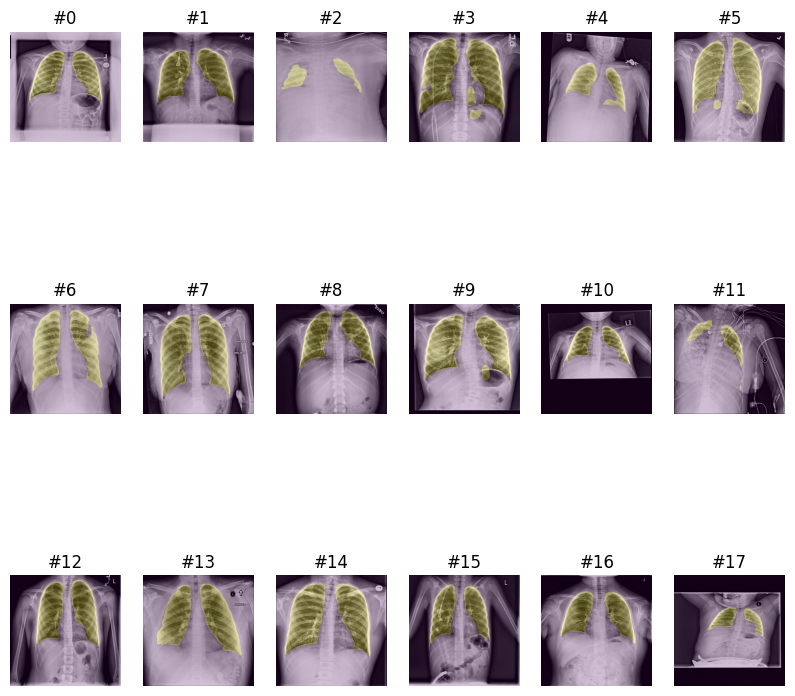

In [ ]:
X0 = imgs_sc
if X0.ndim == 4: X0 = X0[...,0]
M0 = np.load("/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_mask_3400.npy", mmap_mode="r")

idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
plt.figure(figsize=(10,10))
for j,i in enumerate(idxs,1):
    plt.subplot(3,6,j)
    plt.imshow(X0[i], cmap="gray")
    plt.imshow(M0[i], alpha=0.25)
    plt.axis("off")
    plt.title(f"#{i}")
plt.show()

In [ ]:
import numpy as np
from PIL import Image
from pathlib import Path

OUT = Path("/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/thorax_crop_all_512.npy")
SIZE = 512

X_all = imgs_sc
M_all = M0

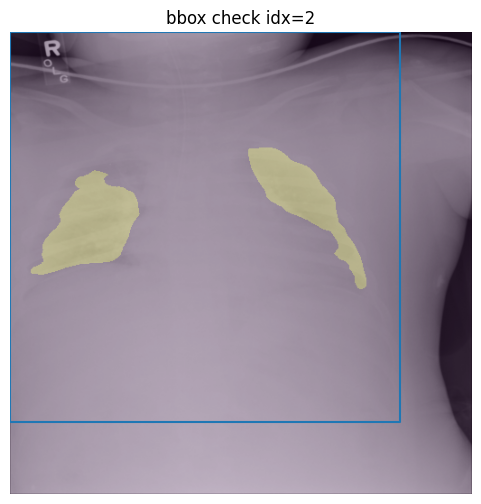

In [ ]:
def central_crop_bbox(H, W, scale=0.75):
    s = int(min(H, W) * scale)
    y1 = (H - s)//2
    x1 = (W - s)//2
    return x1, y1, x1+s, y1+s

def bbox_from_lung_mask_safe(mask, pad_x=0.1, pad_y=0.1, extra_down=0.1, make_square=True,
                            min_area_ratio=0.05):   # ★0.02くらいが実用的
    m = (mask > 0).astype(np.uint8)
    H, W = m.shape

    # morphology
    k = max(3, (min(H, W)//256)*2 + 3)
    kernel = np.ones((k, k), np.uint8)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)

    # ★面積が小さければ中央cropへ
    if m.sum() < H*W*min_area_ratio:
        return central_crop_bbox(H, W, scale=0.75)

    # あとはあなたの bbox 計算と同じ
    ys, xs = np.where(m > 0)
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    bw = (x2 - x1 + 1)
    bh = (y2 - y1 + 1)

    px = int(bw * pad_x)
    py = int(bh * pad_y)
    pd = int(bh * extra_down)

    x1 = max(0, x1 - px)
    x2 = min(W-1, x2 + px)
    y1 = max(0, y1 - py)
    y2 = min(H-1, y2 + py + pd)

    if make_square:
        bw = x2 - x1 + 1
        bh = y2 - y1 + 1
        s = max(bw, bh)
        cx = (x1 + x2)//2
        cy = (y1 + y2)//2

        x1 = cx - s//2
        x2 = x1 + s - 1
        y1 = cy - s//2
        y2 = y1 + s - 1

        if x1 < 0: x2 -= x1; x1 = 0
        if y1 < 0: y2 -= y1; y1 = 0
        if x2 >= W:
            d = x2 - (W-1); x1 -= d; x2 = W-1
            x1 = max(0, x1)
        if y2 >= H:
            d = y2 - (H-1); y1 -= d; y2 = H-1
            y1 = max(0, y1)

    return int(x1), int(y1), int(x2+1), int(y2+1)

import matplotlib.pyplot as plt

i = 2
img = imgs[i]              # (H,W) 0-1
mask = M_all[i]       # (H,W)

x1,y1,x2,y2 = bbox_from_lung_mask_safe(mask)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray", vmin=0, vmax=1)
plt.imshow(mask>0, alpha=0.2)
plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1])
plt.title(f"bbox check idx={i}")
plt.axis("off")
plt.show()

In [ ]:
def crop_resize_norm(img, mask, out_size=512):
    x1,y1,x2,y2 = bbox_from_lung_mask_safe(mask)
    img_c = img[y1:y2, x1:x2]

    # resize + normalize
    img_p = Image.fromarray(img_c.astype(np.float32)).resize((out_size,out_size), Image.BILINEAR)
    x = np.array(img_p, dtype=np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    return x

# ===== ここにあなたの全体データを入れる =====
# X_all: (N,H,W) float32 or uint16/uint8
# M_all: (N,H,W) uint8 (0/1 or 0/255)
# 例：
X_all = imgs_sc
M_all = np.load("/content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/lung_mask_3400.npy", mmap_mode="r")

print("X_all:", X_all.shape, X_all.dtype)
print("M_all:", M_all.shape, M_all.dtype)
assert len(X_all) == len(M_all)

N = len(X_all)
out = np.memmap(OUT, dtype="float32", mode="w+", shape=(N, SIZE, SIZE))

for i in range(N):
    out[i] = crop_resize_norm(X_all[i], M_all[i], out_size=SIZE)
    if (i+1) % 200 == 0:
        print("done", i+1, "/", N)

out.flush()
print("saved:", OUT)

X_all: (3400, 512, 512) float32
M_all: (3400, 512, 512) uint8
done 200 / 3400
done 400 / 3400
done 600 / 3400
done 800 / 3400
done 1000 / 3400
done 1200 / 3400
done 1400 / 3400
done 1600 / 3400
done 1800 / 3400
done 2000 / 3400
done 2200 / 3400
done 2400 / 3400
done 2600 / 3400
done 2800 / 3400
done 3000 / 3400
done 3200 / 3400
done 3400 / 3400
saved: /content/drive/MyDrive/PedAI_ChestXp/512 Resized Compressed Model (npy)/thorax_crop_all_512.npy


In [ ]:
imgs_crop_all = out
assert imgs_crop_all.shape[0] == len(ages) == len(sex)

full_ds = EVACXRDataset(images=imgs_crop_all, ages=ages, sex=sex)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)
test_loader   = DataLoader(test_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=worker_init_fn, generator=g)


In [ ]:
df_results3, probs_dict3 = run_all_models(
    MODEL_NAMES,
    train_loader, val_loader, test_loader,
    age_bins=((0,4),(5,9),(10,14),(15,18)),
    epochs=10,
    base_lr=1e-4,
    save_root="checkpoints_compare",
    use_amp=False,
    save_test_probs=True,
)

print("\n=== Summary ===")
print(df_results3)


MODEL: resnet18
[resnet18] epoch 01/10 loss=0.5093 val_auc=0.899 train_time=36.9s val_pred_time=2.1s lr=0.0001
  -> saved best
[resnet18] epoch 02/10 loss=0.2237 val_auc=0.898 train_time=35.9s val_pred_time=2.0s lr=0.0001
[resnet18] epoch 03/10 loss=0.0829 val_auc=0.878 train_time=36.0s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 04/10 loss=0.0758 val_auc=0.886 train_time=36.3s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 05/10 loss=0.0456 val_auc=0.890 train_time=36.0s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 06/10 loss=0.1169 val_auc=0.904 train_time=35.9s val_pred_time=2.1s lr=0.0001
  -> saved best
[resnet18] epoch 07/10 loss=0.0338 val_auc=0.894 train_time=36.4s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 08/10 loss=0.0125 val_auc=0.908 train_time=36.1s val_pred_time=2.1s lr=0.0001
  -> saved best
[resnet18] epoch 09/10 loss=0.0086 val_auc=0.884 train_time=36.2s val_pred_time=2.1s lr=0.0001
[resnet18] epoch 10/10 loss=0.0092 val_auc=0.885 train_time=36.1s val_pred_time=

In [ ]:
import pandas as pd

# Prepare dataframes with an 'Experiment' identifier
df_baseline = df_results.copy()
df_baseline['experiment'] = 'Baseline'

df_preprocessed = df_results2.copy()
df_preprocessed['experiment'] = 'Preprocessing'

df_cropped = df_results3.copy()
df_cropped['experiment'] = 'Preprocessing + Thoracic Cropping'

# Combine the dataframes
df_all_results = pd.concat([df_baseline, df_preprocessed, df_cropped], ignore_index=True)

# Select and reorder relevant columns for comparison
# Focus on Test AUC (overall) and Age-specific AUCs
comparison_cols = [
    'experiment', 'model', 'test_auc_all',
    'test_auc_0-4', 'test_auc_5-9', 'test_auc_10-14', 'test_auc_15-18'
]

df_summary = df_all_results[comparison_cols].sort_values(['model', 'test_auc_all'], ascending=[True, False])

print("=== Comparison of Experimental Settings ===")
display(df_summary)

=== Comparison of Experimental Settings ===


,experiment,model,test_auc_all,test_auc_0-4,test_auc_5-9,test_auc_10-14,test_auc_15-18
2,Thoracic Cropping,resnet18,0.899536,0.872222,0.775118,0.891331,0.959879
1,Preprocessing,resnet18,0.889443,0.738889,0.763002,0.883155,0.953890
0,Baseline,resnet18,0.865005,0.794444,0.740396,0.834095,0.943471
